In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import noisereduce as nr
import re

#matplotlib.use('Agg')
parent_dir = os.path.dirname(os.getcwd())

C:\Users\sheab\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
file_segment_times = {}

audio_files_path = os.path.join(parent_dir, 'daps_audio', 'cleanraw')
image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

os.makedirs(image_save_path, exist_ok=True)

global_min_db = -40    
global_max_db = 51     
segment_length = 3     
sampling_rate = 44100  
hop_length = 512     
silence_threshold = 0.01
frame_duration = 0.03  #duration for silence removal (30 ms)

def remove_silence(audio, sr, frame_duration=0.03, silence_threshold=0.01):
    frame_length = int(sr * frame_duration)
    hop_length = frame_length
    non_silent_frames = []

    for i in range(0, len(audio), hop_length):
        frame = audio[i:i + frame_length]
        if len(frame) < frame_length:
            break

        frame_energy = np.mean(np.abs(frame))

        if frame_energy > silence_threshold:
            non_silent_frames.append(frame)

    processed_audio = np.concatenate(non_silent_frames) if non_silent_frames else np.array([])
    return processed_audio

def process_audio_file(audio_file):
    file_path = os.path.join(audio_files_path, audio_file)
    audio, sr = librosa.load(r"D:\\ML GUI\\voice recording", sr=sampling_rate)

    second_underscore_index = audio_file.find('_', audio_file.find('_') + 1)
    prefix = audio_file[:second_underscore_index]

    noise_profile = audio[:int(sr * 0.5)]
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile, prop_decrease=0.8)

    cleaned_audio = remove_silence(reduced_noise, sr, frame_duration, silence_threshold)

    samples_per_segment = segment_length * sr
    segment_index = 1

    for i in range(0, len(cleaned_audio), samples_per_segment):
        segment_audio = cleaned_audio[i:i + samples_per_segment]

        if len(segment_audio) >= samples_per_segment:
            save_spectrogram(segment_audio, sr, prefix, segment_index)
            segment_index += 1

    remaining_audio = len(cleaned_audio) % samples_per_segment
    if remaining_audio > 0:
        segment_audio = cleaned_audio[-remaining_audio:]  #slice the last segment
        save_spectrogram(segment_audio, sr, prefix, segment_index)
        #save last segment's length
        last_segment_duration = remaining_audio / sr
        file_segment_times[audio_file] = last_segment_duration
    else:
        last_segment_duration = 0

    with open(os.path.join("D:\\ML GUI\\spectrograms", "segmentlast_times.txt"), "a") as f:
            f.write(f"{prefix}_segment{segment_index}.png: {last_segment_duration:.2f} seconds\n")

    if len(cleaned_audio) == 0:
        print(f"Warning: {audio_file} was completely silent after processing.")


def save_spectrogram(segment_audio, sr, prefix, segment_index):
    stft = librosa.stft(segment_audio)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    plt.figure(figsize=(4, 5), dpi=100)
    librosa.display.specshow(stft_db, sr=sr, x_axis=None, y_axis=None, 
                             vmin=global_min_db, vmax=global_max_db, cmap='gray')
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    segment_filename = f"{prefix}_segment{segment_index}.png"
    plt.savefig(os.path.join("D:\\ML GUI\\spectrograms", segment_filename), bbox_inches='tight', pad_inches=0)
    plt.close()

for audio_file in os.listdir("D:\\ML GUI\\voice recording"):
    if audio_file.endswith(".wav"):
        print(f"Processing {audio_file} for spectrograms...")
        process_audio_file(audio_file)
        
print(f"All spectrograms have been saved successfully.")
print("Last segment times have been recorded in 'segmentlast_times.txt'.")

Processing voice_recording.wav for spectrograms...


KeyboardInterrupt: 

In [14]:
#not cleaned spectos for eda

file_segment_times = {}

audio_files_path = os.path.join(parent_dir, 'daps_audio', 'cleanraw')
image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_nocleantrim')

os.makedirs(image_save_path, exist_ok=True)

global_min_db = -40    
global_max_db = 51     
segment_length = 3     
sampling_rate = 44100  
hop_length = 512     
silence_threshold = 0.01

def process_audio_file(audio_file):
    file_path = os.path.join(audio_files_path, audio_file)
    audio, sr = librosa.load(file_path, sr=sampling_rate)

    second_underscore_index = audio_file.find('_', audio_file.find('_') + 1)
    prefix = audio_file[:second_underscore_index]

    samples_per_segment = segment_length * sr
    segment_index = 1

    for i in range(0, len(audio), samples_per_segment):
        segment_audio = audio[i:i + samples_per_segment]

        if len(segment_audio) >= samples_per_segment:
            save_spectrogram(segment_audio, sr, prefix, segment_index)
            segment_index += 1

    remaining_audio = len(audio) % samples_per_segment
    if remaining_audio > 0:
        segment_audio = audio[-remaining_audio:]  #slice the last segment
        save_spectrogram(segment_audio, sr, prefix, segment_index)
        #save last segment's length
        last_segment_duration = remaining_audio / sr
        file_segment_times[audio_file] = last_segment_duration
    else:
        last_segment_duration = 0

    with open(os.path.join(image_save_path, "segmentlast_times.txt"), "a") as f:
            f.write(f"{prefix}_segment{segment_index}.png: {last_segment_duration:.2f} seconds\n")

    if len(audio) == 0:
        print(f"Warning: {audio_file} was completely silent after processing.")


def save_spectrogram(segment_audio, sr, prefix, segment_index):
    stft = librosa.stft(segment_audio)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    plt.figure(figsize=(4, 5), dpi=100)
    librosa.display.specshow(stft_db, sr=sr, x_axis=None, y_axis=None, 
                             vmin=global_min_db, vmax=global_max_db, cmap='gray')
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    segment_filename = f"{prefix}_segment{segment_index}.png"
    plt.savefig(os.path.join(image_save_path, segment_filename), bbox_inches='tight', pad_inches=0)
    plt.close()

for audio_file in os.listdir(audio_files_path):
    if audio_file.endswith(".wav"):
        print(f"Processing {audio_file} for spectrograms...")
        process_audio_file(audio_file)
        
print(f"All spectrograms have been saved successfully.")
print("Last segment times have been recorded in 'segmentlast_times.txt'.")

Processing f10_script1_cleanraw.wav for spectrograms...
Processing f10_script2_cleanraw.wav for spectrograms...
Processing f10_script3_cleanraw.wav for spectrograms...
Processing f10_script4_cleanraw.wav for spectrograms...
Processing f10_script5_cleanraw.wav for spectrograms...
Processing f1_script1_cleanraw.wav for spectrograms...
Processing f1_script2_cleanraw.wav for spectrograms...
Processing f1_script3_cleanraw.wav for spectrograms...
Processing f1_script4_cleanraw.wav for spectrograms...
Processing f1_script5_cleanraw.wav for spectrograms...
Processing f2_script1_cleanraw.wav for spectrograms...
Processing f2_script2_cleanraw.wav for spectrograms...
Processing f2_script3_cleanraw.wav for spectrograms...
Processing f2_script4_cleanraw.wav for spectrograms...
Processing f2_script5_cleanraw.wav for spectrograms...
Processing f3_script1_cleanraw.wav for spectrograms...
Processing f3_script2_cleanraw.wav for spectrograms...
Processing f3_script3_cleanraw.wav for spectrograms...
Proce

In [24]:
file_segment_times = {}

# speaker_prefix = "f10_" 
audio_files_path = os.path.join(parent_dir, 'daps_audio', 'cleanraw')
image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_class1_stretch035')

os.makedirs(image_save_path, exist_ok=True)
class1_files = ["f1_", "f7_", "f8_", "m3_", "m6_", "m8_"]

global_min_db = -40    
global_max_db = 51     
segment_length = 3     
sampling_rate = 44100  
hop_length = 512     
silence_threshold = 0.01
frame_duration = 0.03  #duration for silence removal (30 ms)

def stretch_audio(audio, stretch_factor=0.35):
    return librosa.effects.time_stretch(audio, rate=stretch_factor)

def remove_silence(audio, sr, frame_duration=0.03, silence_threshold=0.01):
    frame_length = int(sr * frame_duration)
    hop_length = frame_length
    non_silent_frames = []

    for i in range(0, len(audio), hop_length):
        frame = audio[i:i + frame_length]
        if len(frame) < frame_length:
            break

        frame_energy = np.mean(np.abs(frame))

        if frame_energy > silence_threshold:
            non_silent_frames.append(frame)

    processed_audio = np.concatenate(non_silent_frames) if non_silent_frames else np.array([])
    return processed_audio

def process_audio_file(audio_file):
    file_path = os.path.join(audio_files_path, audio_file)
    audio, sr = librosa.load(file_path, sr=sampling_rate)

    second_underscore_index = audio_file.find('_', audio_file.find('_') + 1)
    prefix = audio_file[:second_underscore_index]

    audio = stretch_audio(audio, stretch_factor=0.35)

    noise_profile = audio[:int(sr * 0.5)]
    reduced_noise = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile, prop_decrease=0.8)

    cleaned_audio = remove_silence(reduced_noise, sr, frame_duration, silence_threshold)

    samples_per_segment = segment_length * sr
    segment_index = 1

    for i in range(0, len(cleaned_audio), samples_per_segment):
        segment_audio = cleaned_audio[i:i + samples_per_segment]

        if len(segment_audio) >= samples_per_segment:
            save_spectrogram(segment_audio, sr, prefix, segment_index)
            segment_index += 1

    remaining_audio = len(cleaned_audio) % samples_per_segment
    if remaining_audio > 0:
        segment_audio = cleaned_audio[-remaining_audio:]  #slice the last segment
        save_spectrogram(segment_audio, sr, prefix, segment_index)
        #save last segment's length
        last_segment_duration = remaining_audio / sr
        file_segment_times[audio_file] = last_segment_duration
        with open(os.path.join(image_save_path, "segmentlast_times.txt"), "a") as f:
            f.write(f"{prefix}_segment{segment_index}.png: {last_segment_duration:.2f} seconds\n")

    if len(cleaned_audio) == 0:
        print(f"Warning: {audio_file} was completely silent after processing.")


def save_spectrogram(segment_audio, sr, prefix, segment_index):
    stft = librosa.stft(segment_audio)
    stft_db = librosa.amplitude_to_db(np.abs(stft))
    plt.figure(figsize=(4, 5), dpi=100)
    librosa.display.specshow(stft_db, sr=sr, x_axis=None, y_axis=None, 
                             vmin=global_min_db, vmax=global_max_db, cmap='gray')
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    segment_filename = f"{prefix}_segment{segment_index}.png"
    plt.savefig(os.path.join(image_save_path, segment_filename), bbox_inches='tight', pad_inches=0)
    plt.close()

for audio_file in os.listdir(audio_files_path):
    if any(audio_file.startswith(prefix) for prefix in class1_files) and audio_file.endswith(".wav"):
        print(f"Augmenting audio file {audio_file} with stretching...")
        process_audio_file(audio_file)
        
print(f"All spectrograms have been saved successfully.")
print(f"Last segment times have been recorded in 'segmentlast_times.txt'.")

Augmenting audio file f1_script1_cleanraw.wav with stretching...
Augmenting audio file f1_script2_cleanraw.wav with stretching...
Augmenting audio file f1_script3_cleanraw.wav with stretching...
Augmenting audio file f1_script4_cleanraw.wav with stretching...
Augmenting audio file f1_script5_cleanraw.wav with stretching...
Augmenting audio file f7_script1_cleanraw.wav with stretching...
Augmenting audio file f7_script2_cleanraw.wav with stretching...
Augmenting audio file f7_script3_cleanraw.wav with stretching...
Augmenting audio file f7_script4_cleanraw.wav with stretching...
Augmenting audio file f7_script5_cleanraw.wav with stretching...
Augmenting audio file f8_script1_cleanraw.wav with stretching...
Augmenting audio file f8_script2_cleanraw.wav with stretching...
Augmenting audio file f8_script3_cleanraw.wav with stretching...
Augmenting audio file f8_script4_cleanraw.wav with stretching...
Augmenting audio file f8_script5_cleanraw.wav with stretching...
Augmenting audio file m3_

In [18]:
augm_class1_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_class1_stretch035')
nrml_img_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

class1_files = ["f1_", "f7_", "f8_", "m3_", "m6_", "m8_"]

augm_class1_png_count = 0
class0_png_count = 0

for file in os.listdir(nrml_img_path):
    if file.endswith(".png") and not any(file.startswith(prefix) for prefix in class1_files):
        class0_png_count += 1

for file in os.listdir(augm_class1_path):
    if file.endswith(".png"):
        augm_class1_png_count += 1

print(f"Number of spectogram files in class0: {class0_png_count}")
print(f"Number of augmented spectogram files in class1: {augm_class1_png_count}")

Number of spectogram files in class0: 1910
Number of augmented spectogram files in class1: 1907


### USAGE EXAMPLES OF .TXT

In [24]:
def calculate_script_duration(line):
    match = re.match(r"(.*)_segment(\d+)\.png: (\d+\.\d+) seconds", line)
    if match:
        file_name = match.group(1)
        segment_number = int(match.group(2))
        last_duration = float(match.group(3))
        
        total_duration = (segment_number - 1) * 3 + last_duration
        
        return file_name, total_duration
    return None, None

def process_file(file_path):
    results = []
    with open(file_path, 'r') as file:
        for line in file:
            file_name, total_duration = calculate_script_duration(line.strip())
            if file_name and total_duration is not None:
                results.append((file_name, total_duration))
    return results

file_path = os.path.join(nrml_img_path, "segmentlast_times.txt")
try:
    results = process_file(file_path)
    for i, (file_name, duration) in enumerate(results, start=1):
        print(f"{file_name}: {duration:.2f} seconds")
except Exception as e:
    print(f"Error: {e}")

f10_script1: 93.27 seconds
f10_script2: 95.88 seconds
f10_script3: 92.10 seconds
f10_script4: 78.00 seconds
f10_script5: 77.94 seconds
f1_script1: 78.21 seconds
f1_script2: 81.36 seconds
f1_script3: 74.79 seconds
f1_script4: 61.20 seconds
f1_script5: 70.05 seconds
f2_script1: 94.68 seconds
f2_script2: 101.34 seconds
f2_script3: 87.12 seconds
f2_script4: 78.87 seconds
f2_script5: 86.28 seconds
f3_script1: 96.63 seconds
f3_script2: 104.01 seconds
f3_script3: 93.45 seconds
f3_script4: 76.44 seconds
f3_script5: 81.33 seconds
f4_script1: 92.49 seconds
f4_script2: 100.20 seconds
f4_script3: 90.21 seconds
f4_script4: 77.52 seconds
f4_script5: 84.69 seconds
f5_script1: 87.96 seconds
f5_script2: 95.94 seconds
f5_script3: 84.96 seconds
f5_script4: 73.83 seconds
f5_script5: 81.60 seconds
f6_script1: 70.02 seconds
f6_script2: 69.48 seconds
f6_script3: 64.47 seconds
f6_script4: 57.03 seconds
f6_script5: 54.75 seconds
f7_script1: 84.48 seconds
f7_script2: 85.38 seconds
f7_script3: 80.91 seconds
f7_s

In [26]:
for prefix in [f"f{i}_" for i in range(1, 11)] + [f"m{i}_" for i in range(1, 11)]:
    total_duration = sum(duration for file_name, duration in results if file_name.startswith(prefix))
    print(f"Total duration for {prefix}: {total_duration:.2f} seconds")

Total duration for f1_: 365.61 seconds
Total duration for f2_: 448.29 seconds
Total duration for f3_: 451.86 seconds
Total duration for f4_: 445.11 seconds
Total duration for f5_: 424.29 seconds
Total duration for f6_: 315.75 seconds
Total duration for f7_: 384.00 seconds
Total duration for f8_: 385.68 seconds
Total duration for f9_: 371.64 seconds
Total duration for f10_: 437.19 seconds
Total duration for m1_: 297.57 seconds
Total duration for m2_: 431.91 seconds
Total duration for m3_: 450.30 seconds
Total duration for m4_: 463.71 seconds
Total duration for m5_: 468.99 seconds
Total duration for m6_: 366.81 seconds
Total duration for m7_: 399.54 seconds
Total duration for m8_: 446.73 seconds
Total duration for m9_: 253.41 seconds
Total duration for m10_: 416.94 seconds


### EDA: NORMAL SPECTOGRAMS VS AUGMENTED SPECTOGRAMS

In [41]:
image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

augm_class1_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_class1_stretch035')
nrml_img_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

class1_files = ["f1_", "f7_", "f8_", "m3_", "m6_", "m8_"]

In [11]:
augm_class1_png_count = 0
class1_png_count = 0

for file in os.listdir(nrml_img_path):
    if file.endswith(".png") and any(file.startswith(prefix) for prefix in class1_files):
        class1_png_count += 1

for file in os.listdir(augm_class1_path):
    if file.endswith(".png"):
        augm_class1_png_count += 1

print(f"Number of normal spectogram files in class1: {class1_png_count}")
print(f"Number of augmented spectogram files in class1: {augm_class1_png_count}")

Number of normal spectogram files in class1: 813
Number of augmented spectogram files in class1: 1907


In [25]:
def calculate_script_duration(line):
    match = re.match(r"(.*)_segment(\d+)\.png: (\d+\.\d+) seconds", line)
    if match:
        file_name = match.group(1)
        segment_number = int(match.group(2))
        last_duration = float(match.group(3))
        
        total_duration = (segment_number - 1) * 3 + last_duration
        
        return file_name, total_duration
    return None, None

def process_class1_file(file_path):
    results = []
    with open(file_path, 'r') as file:
        for line in file:
            file_name, total_duration = calculate_script_duration(line.strip())
            if file_name and total_duration is not None:
                if any(file_name.startswith(prefix) for prefix in class1_files):
                    results.append((file_name, total_duration))
    return results

file_path_1 = os.path.join(nrml_img_path, "segmentlast_times.txt")
file_path_2 = os.path.join(augm_class1_path, "segmentlast_times.txt")

try:
    results_1 = process_class1_file(file_path_1)
except Exception as e:
    print(f"Error processing normal spectograms: {e}")
    results_1 = []

try:
    results_2 = process_class1_file(file_path_2)
except Exception as e:
    print(f"Error processing augmented spectograms: {e}")
    results_2 = []

for (file_name_1, duration_1), (file_name_2, duration_2) in zip(results_1, results_2):
    print(f"{file_name_1}: Normal = {duration_1:.2f} seconds, Augmented = {duration_2:.2f} seconds")

f1_script1: Normal = 78.21 seconds, Augmented = 189.75 seconds
f1_script2: Normal = 81.36 seconds, Augmented = 201.30 seconds
f1_script3: Normal = 74.79 seconds, Augmented = 176.73 seconds
f1_script4: Normal = 61.20 seconds, Augmented = 146.70 seconds
f1_script5: Normal = 70.05 seconds, Augmented = 172.11 seconds
f7_script1: Normal = 84.48 seconds, Augmented = 196.20 seconds
f7_script2: Normal = 85.38 seconds, Augmented = 200.40 seconds
f7_script3: Normal = 80.91 seconds, Augmented = 187.41 seconds
f7_script4: Normal = 64.86 seconds, Augmented = 145.92 seconds
f7_script5: Normal = 68.37 seconds, Augmented = 150.30 seconds
f8_script1: Normal = 79.59 seconds, Augmented = 190.89 seconds
f8_script2: Normal = 83.55 seconds, Augmented = 195.15 seconds
f8_script3: Normal = 76.83 seconds, Augmented = 186.57 seconds
f8_script4: Normal = 63.39 seconds, Augmented = 150.39 seconds
f8_script5: Normal = 82.32 seconds, Augmented = 203.34 seconds
m3_script1: Normal = 103.62 seconds, Augmented = 253.08

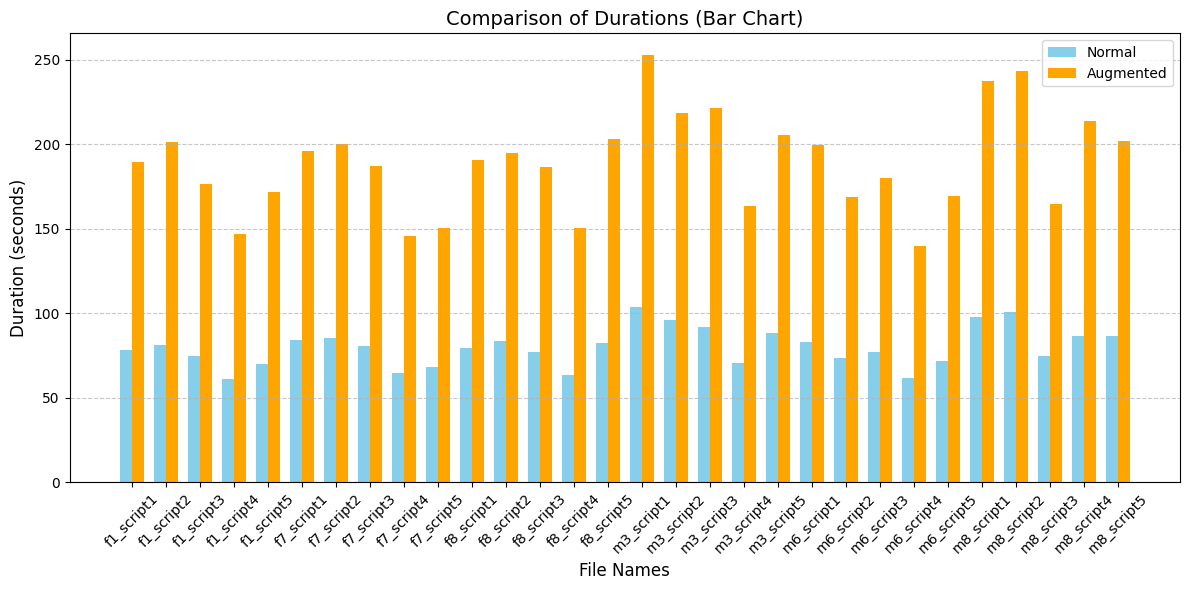

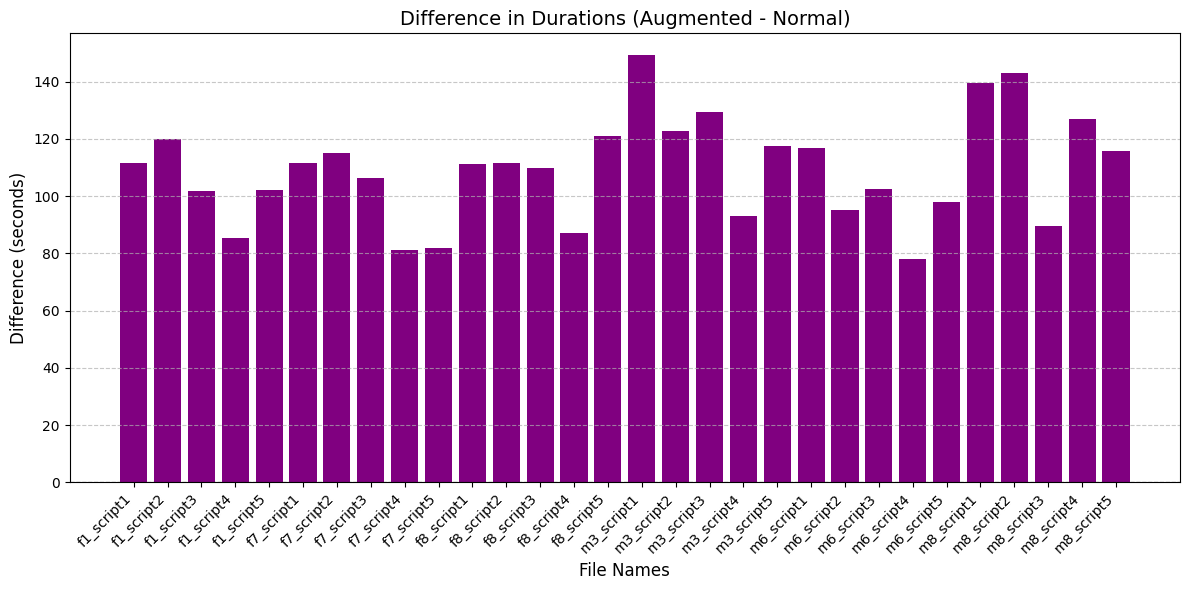

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Bar Chart
plt.figure(figsize=(12, 6))
x = np.arange(len(file_names))
width = 0.35

differences = [aug - norm for aug, norm in zip(augmented_durations, normal_durations)]

plt.bar(x - width / 2, normal_durations, width, label='Normal', color='skyblue')
plt.bar(x + width / 2, augmented_durations, width, label='Augmented', color='orange')
plt.title('Comparison of Durations (Bar Chart)', fontsize=14)
plt.xlabel('File Names', fontsize=12)
plt.ylabel('Duration (seconds)', fontsize=12)
plt.xticks(x, file_names, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Difference Plot
plt.figure(figsize=(12, 6))
plt.bar(file_names, differences, color='purple')
plt.title('Difference in Durations (Augmented - Normal)', fontsize=14)
plt.xlabel('File Names', fontsize=12)
plt.ylabel('Difference (seconds)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
for prefix in class1_files:
    total_duration_1 = sum(duration for file_name, duration in results_1 if file_name.startswith(prefix))
    total_duration_2 = sum(duration for file_name, duration in results_2 if file_name.startswith(prefix))
    
    print(f"Total duration for {prefix}: Normal = {total_duration_1:.2f} seconds, Augmented = {total_duration_2:.2f} seconds")

Total duration for f1_: Normal = 365.61 seconds, Augmented = 886.59 seconds
Total duration for f7_: Normal = 384.00 seconds, Augmented = 880.23 seconds
Total duration for f8_: Normal = 385.68 seconds, Augmented = 926.34 seconds
Total duration for m3_: Normal = 450.30 seconds, Augmented = 1062.30 seconds
Total duration for m6_: Normal = 366.81 seconds, Augmented = 857.82 seconds
Total duration for m8_: Normal = 446.73 seconds, Augmented = 1061.55 seconds


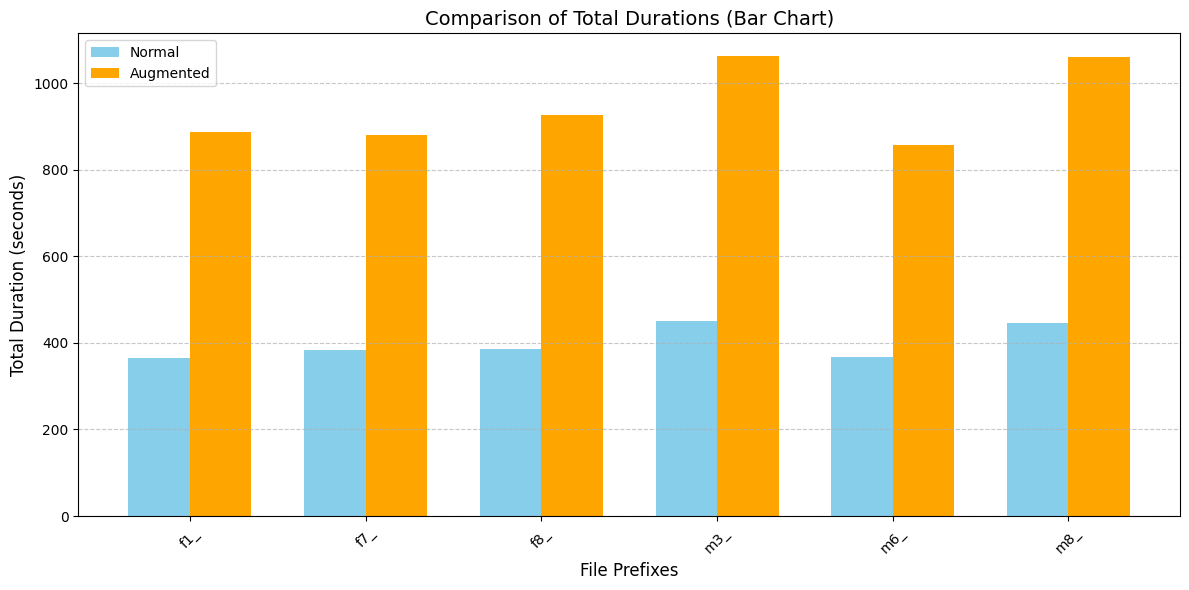

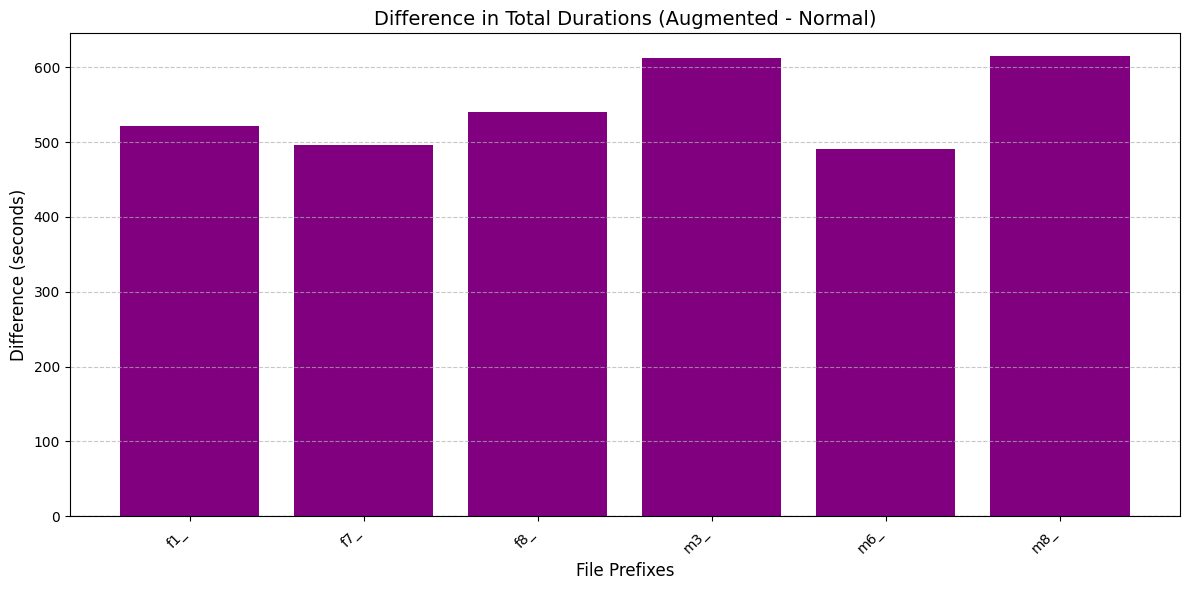

In [32]:
# Bar Chart
plt.figure(figsize=(12, 6))
x = np.arange(len(class1_files))
width = 0.35

total_durations_1 = []
total_durations_2 = []
for prefix in class1_files:
    total_duration_1 = sum(duration for file_name, duration in results_1 if file_name.startswith(prefix))
    total_duration_2 = sum(duration for file_name, duration in results_2 if file_name.startswith(prefix))
    total_durations_1.append(total_duration_1)
    total_durations_2.append(total_duration_2)

differences = [aug - norm for aug, norm in zip(total_durations_2, total_durations_1)]

plt.bar(x - width / 2, total_durations_1, width, label='Normal', color='skyblue')
plt.bar(x + width / 2, total_durations_2, width, label='Augmented', color='orange')
plt.title('Comparison of Total Durations (Bar Chart)', fontsize=14)
plt.xlabel('File Prefixes', fontsize=12)
plt.ylabel('Total Duration (seconds)', fontsize=12)
plt.xticks(x, class1_files, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Difference Plot
plt.figure(figsize=(12, 6))
plt.bar(class1_files, differences, color='purple')
plt.title('Difference in Total Durations (Augmented - Normal)', fontsize=14)
plt.xlabel('File Prefixes', fontsize=12)
plt.ylabel('Difference (seconds)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

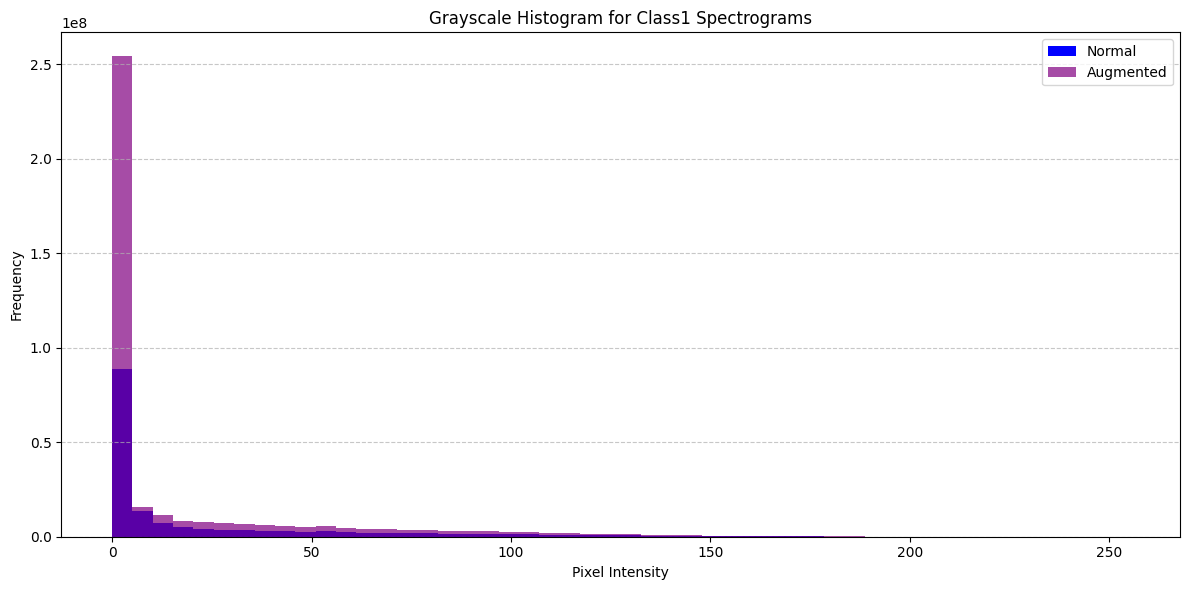

In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

augm_class1_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_class1_stretch035')
nrml_img_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

class1_files = ["f1_", "f7_", "f8_", "m3_", "m6_", "m8_"]

hist_nrml = np.zeros(256)
hist_augm = np.zeros(256)

for file_name in os.listdir(nrml_img_path):
    if any(file_name.startswith(prefix) for prefix in class1_files) and file_name.endswith('.png'):
        img_path = os.path.join(nrml_img_path, file_name)
        img = Image.open(img_path).convert('L')
        hist_nrml += np.array(img.histogram())

for file_name in os.listdir(augm_class1_path):
    if file_name.endswith('.png'):
        img_path = os.path.join(augm_class1_path, file_name)
        img = Image.open(img_path).convert('L')
        hist_augm += np.array(img.histogram())

plt.figure(figsize=(12, 6))

plt.hist(np.arange(256), bins=50, weights=hist_nrml, color='blue', alpha=1, label='Normal')
plt.hist(np.arange(256), bins=50, weights=hist_augm, color='purple', alpha=0.7, label='Augmented')

plt.title('Grayscale Histogram for Class1 Spectrograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

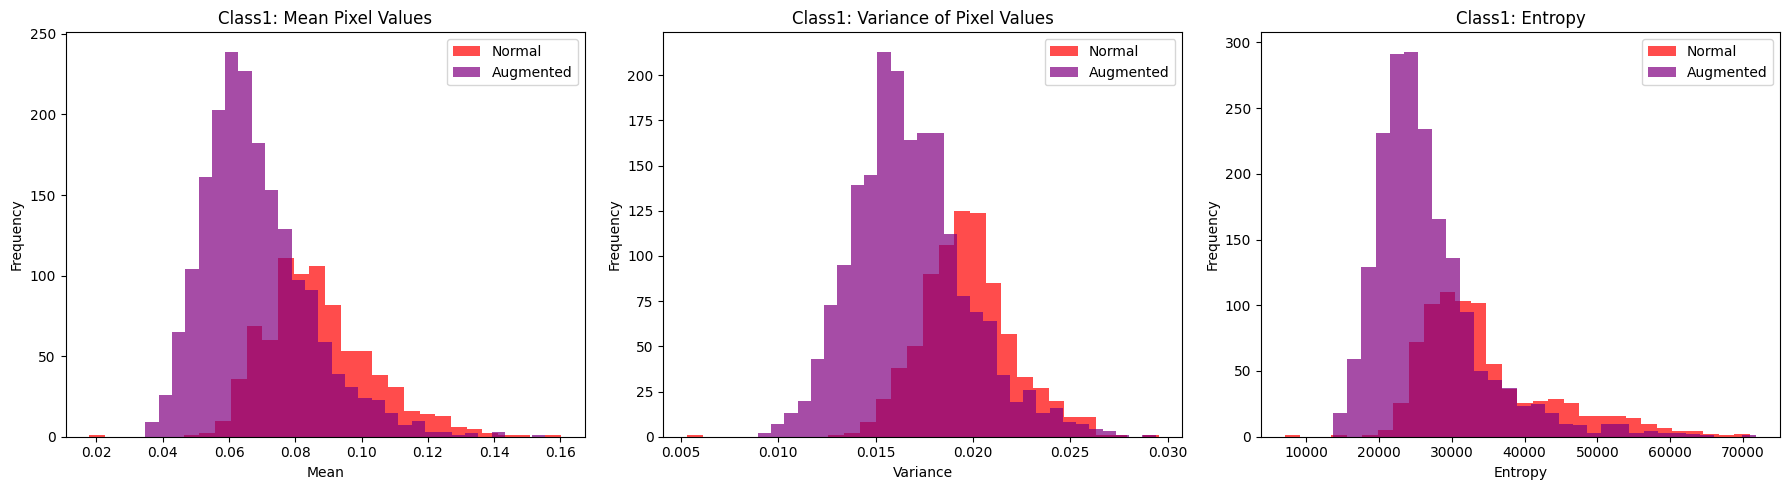

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_save_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

augm_class1_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_class1_stretch035')
nrml_img_path = os.path.join(parent_dir, 'daps_images', 'cleanraw_images', 'sec3_noaxes')

class1_files = ["f1_", "f7_", "f8_", "m3_", "m6_", "m8_"]

means_nrml = []
variances_nrml = []
entropies_nrml = []

means_augm = []
variances_augm = []
entropies_augm = []

for file_name in os.listdir(nrml_img_path):
    if any(file_name.startswith(prefix) for prefix in class1_files) and file_name.endswith('.png'):
        img_path = os.path.join(nrml_img_path, file_name)
        
        spectrogram_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if spectrogram_img is not None:
            #normalize the pixel values to range [0, 1]
            spectrogram_img = spectrogram_img / 255.0

            mean = np.mean(spectrogram_img)
            variance = np.var(spectrogram_img)
            entropy = -np.sum(spectrogram_img * np.log2(spectrogram_img + 1e-10))  # Shannon entropy

            means_nrml.append(mean)
            variances_nrml.append(variance)
            entropies_nrml.append(entropy)

for file_name in os.listdir(augm_class1_path):
    if file_name.endswith(".png"):
        img_path = os.path.join(augm_class1_path, file_name)
        
        spectrogram_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if spectrogram_img is not None:
            #normalize the pixel values to range [0, 1]
            spectrogram_img = spectrogram_img / 255.0

            mean = np.mean(spectrogram_img)
            variance = np.var(spectrogram_img)
            entropy = -np.sum(spectrogram_img * np.log2(spectrogram_img + 1e-10))  # Shannon entropy

            means_augm.append(mean)
            variances_augm.append(variance)
            entropies_augm.append(entropy)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(means_nrml, bins=30, color='red', alpha=0.7, label='Normal')
plt.hist(means_augm, bins=30, color='purple', alpha=0.7, label='Augmented')
plt.title('Class1: Mean Pixel Values')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(variances_nrml, bins=30, color='red', alpha=0.7, label='Normal')
plt.hist(variances_augm, bins=30, color='purple', alpha=0.7, label='Augmented')
plt.title('Class1: Variance of Pixel Values')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(entropies_nrml, bins=30, color='red', alpha=0.7, label='Normal')
plt.hist(entropies_augm, bins=30, color='purple', alpha=0.7, label='Augmented')
plt.title('Class1: Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()